<a href="https://colab.research.google.com/github/charlesm93/stan_tutorial/blob/main/Stan_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
rm(list = ls())
gc()

set.seed(1954)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,782439,41.8,1410295,75.4,1410295,75.4
Vcells,1400968,10.7,8388608,64.0,2236096,17.1


## Install requisite packages

In [49]:
install_packages <- TRUE
if (install_packages) {
  install.packages("rjson")
  install.packages("posterior")
  install.packages("bayesplot")
  install.packages("outbreak")
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘outbreak’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [16]:
if (install_packages) {
  install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
  library(cmdstanr)
  install_cmdstan()
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Load packages

In [18]:
library(rjson)
library(bayesplot)
library(posterior)
library(ggplot2)
library(cmdstanr)

## Bayesian linear regression

In [19]:
data <- list(N = 10,
             x = 1:10,
             y = c(12.03037, 13.86786, 16.00795, 18.29419, 20.26679, 22.38664,
                   23.95751, 25.71993, 28.09961, 30.46859))


In [20]:
# define starting distribution
init <- function() {
  list(sigma = rgamma(1, 1),
       beta = rnorm(1, mean = 1, sd = 1))
}

In [41]:
# transpile (translate Stan to C++ and then compile)
mod <- cmdstan_model("model/linear.stan")


In [ ]:
# run sampler
n_chains <- 4
fit <- mod$sample(data = data, chains = n_chains,
                  init = init,
                  save_warmup = TRUE,
                  parallel_chains = 4)


In [ ]:
# Examine Stan's default summaries
fit$summary()

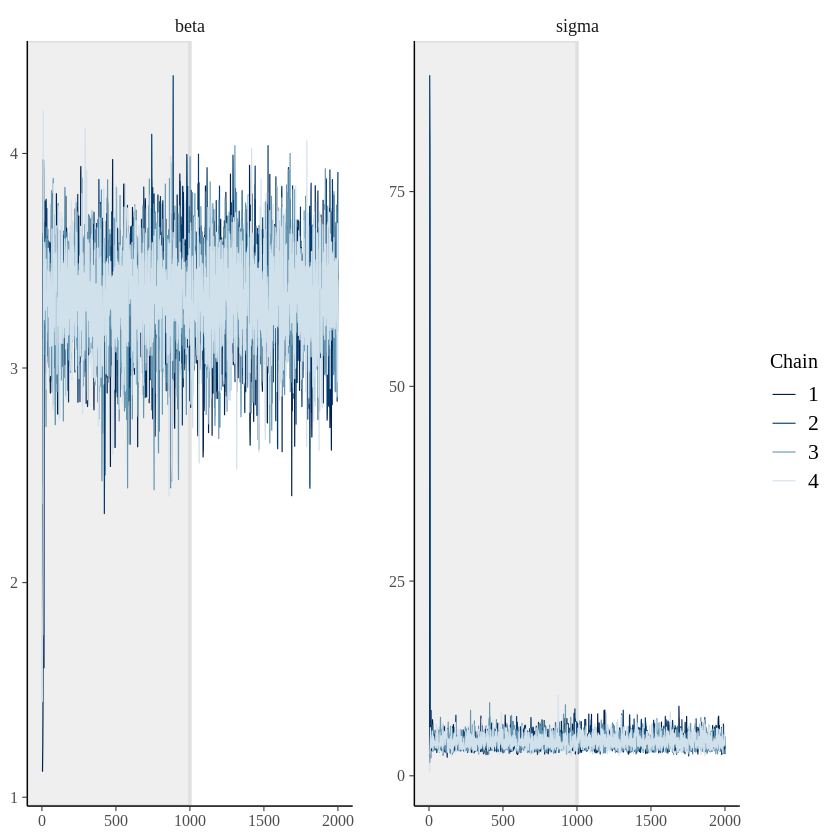

In [27]:
# Construct diagnostic plots
pars <- c("beta", "sigma")
bayesplot::mcmc_trace(fit$draws(inc_warmup = TRUE),
                      n_warmup = 1000, pars = pars)

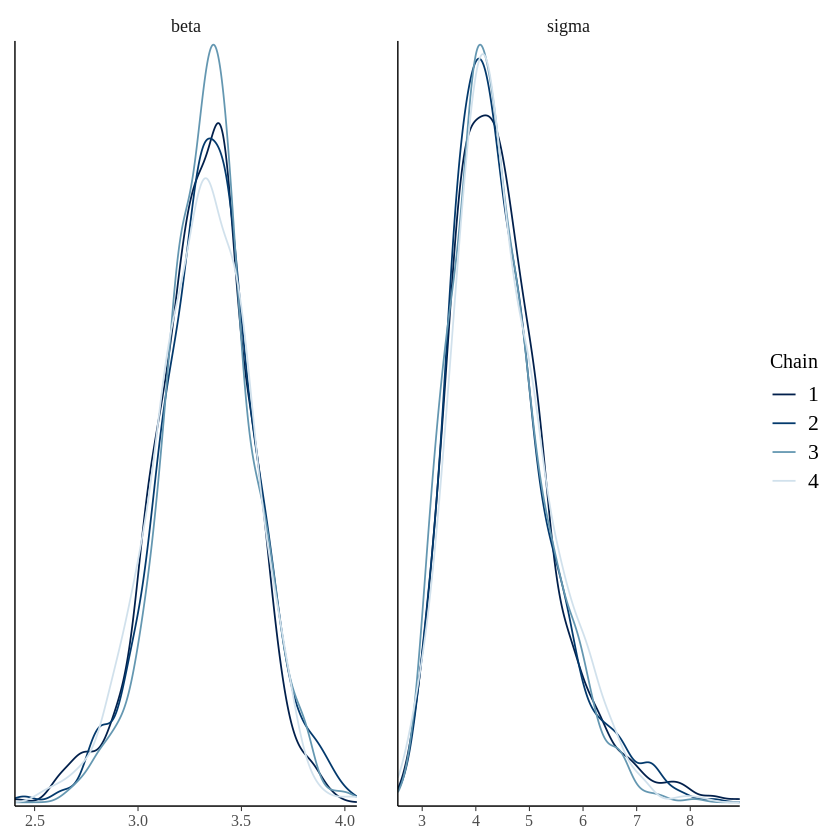

In [28]:
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)

In [46]:
# Extract posterior predictive checks
yrep <- as.matrix(
  as_draws_df(fit$draws(variables = c("y_pred"))))
head(yrep)


y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10],.chain,.iteration,.draw
4.86806,3.62836,6.801570,7.45162,18.2068,18.4817,21.1750,11.9914,24.9719,34.6554,1,1,1
6.32688,6.28431,8.398340,18.58740,14.8454,20.3731,21.8031,24.9944,27.7170,38.9745,1,2,2
4.88434,8.82639,8.065650,13.50000,18.1344,22.6704,30.7875,25.2860,31.1539,30.6440,1,3,3
-4.55767,3.85820,3.453230,12.25460,19.1781,19.6220,21.4395,22.3202,18.9741,29.1697,1,4,4
6.06417,-3.24502,-0.104017,15.52770,21.3576,17.9893,21.9110,22.7164,27.3915,34.6654,1,5,5
4.31985,11.07970,5.441600,19.57480,13.1623,15.4626,30.3674,24.2185,37.1663,33.0855,1,6,6


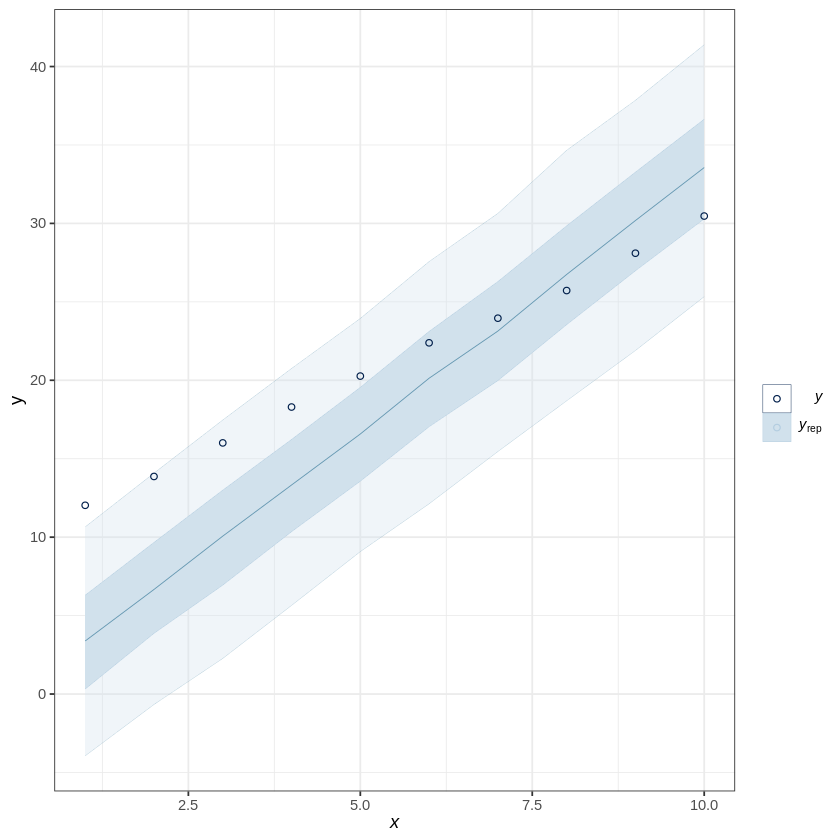

In [47]:
# We don't need the chain, iteration and draw ID, so let's remove them.
yrep <- yrep[, -(11:13)]

# Plot the posterior predictions and compare it to the real data.
bayesplot::ppc_ribbon(y = data$y, yrep = yrep, x = data$x,
                      y_draw = "point") +
  theme_bw() +
  ylab("y")


## SIR model

In [55]:
N = 763
data_sir <- list(
  cases = c(3, 8, 26, 76, 225, 298, 258, 233, 189, 128, 68, 29, 14, 4),
  N = N,
  n_days = 14,
  ts = seq(0, 14, by = 1)[-1],
  t0 = 0,

  #initial conditions
  y0 = c(S = N - 1, I = 1, R = 0)
)



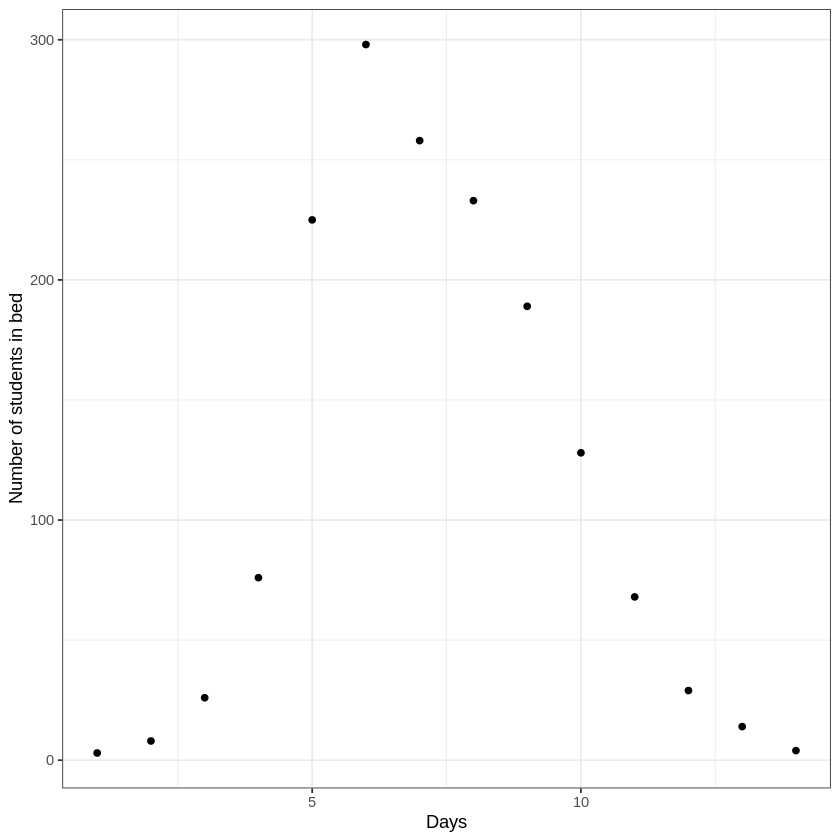

In [57]:
# plot the data, obtained from outbreaks
theme_set(theme_bw())
ggplot(data = data.frame(x = data_sir$ts, y = data_sir$cases)) +
  geom_point(mapping = aes(x = x, y = y)) +
  labs(y = "Number of students in bed") +
  labs(x = "Days")


In [58]:
# define starting distribution
init <- function() {
  list(beta = abs(rnorm(1, mean = 2, sd = 1)),
       gamma = abs(rnorm(1, mean = 0.4, sd = 0.5)),
       phi_inv = rexp(1, rate = 5))
}

# transpile (translate Stan to C++ and then compile)
mod <- cmdstan_model("model/sir.stan")


In [ ]:
n_chains <- 4
fit <- mod$sample(data = data_sir,
                  chains = n_chains,
                  parallel_chains = n_chains,
                  init = init,
                  save_warmup = TRUE)


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-65.4604440,-65.0865500,1.36007036,1.06361724,-68.18709500,-64.0072850,1.0018898,1459.457,1921.294
gamma,0.5427073,0.5412365,0.04615425,0.04216292,0.47010640,0.6197073,1.0004555,2907.450,2154.618
beta,1.7334880,1.7328250,0.05182030,0.04940023,1.65133600,1.8176505,1.0025250,2299.821,1857.032
phi_inv,0.1388627,0.1220005,0.07579771,0.06134109,0.05070218,0.2844924,1.0032640,2303.139,2152.694
phi,9.4593105,8.1966800,5.43619123,4.08357707,3.51504050,19.7230000,1.0032641,2303.095,2152.694
"y[1,1]",758.6815980,758.6970000,0.20645721,0.18829020,758.33600000,758.9930000,1.0013945,2550.715,2036.780
"y[2,1]",747.9433767,748.0900000,1.52776059,1.35213120,745.30990000,750.1221000,1.0015666,2716.640,2254.869
"y[3,1]",714.8356595,715.7275000,7.41185506,6.44337960,701.99855000,724.9798500,1.0015018,2798.255,2280.591
"y[4,1]",627.0851470,629.7890000,24.57354880,21.77049840,584.09490000,661.0193000,1.0020433,2854.619,2126.340


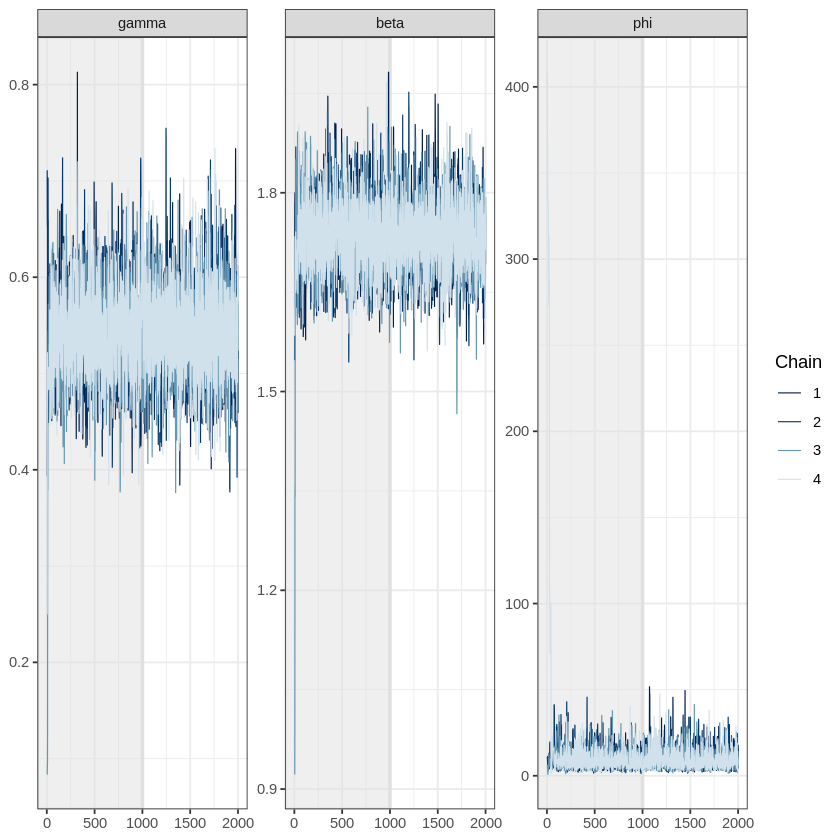

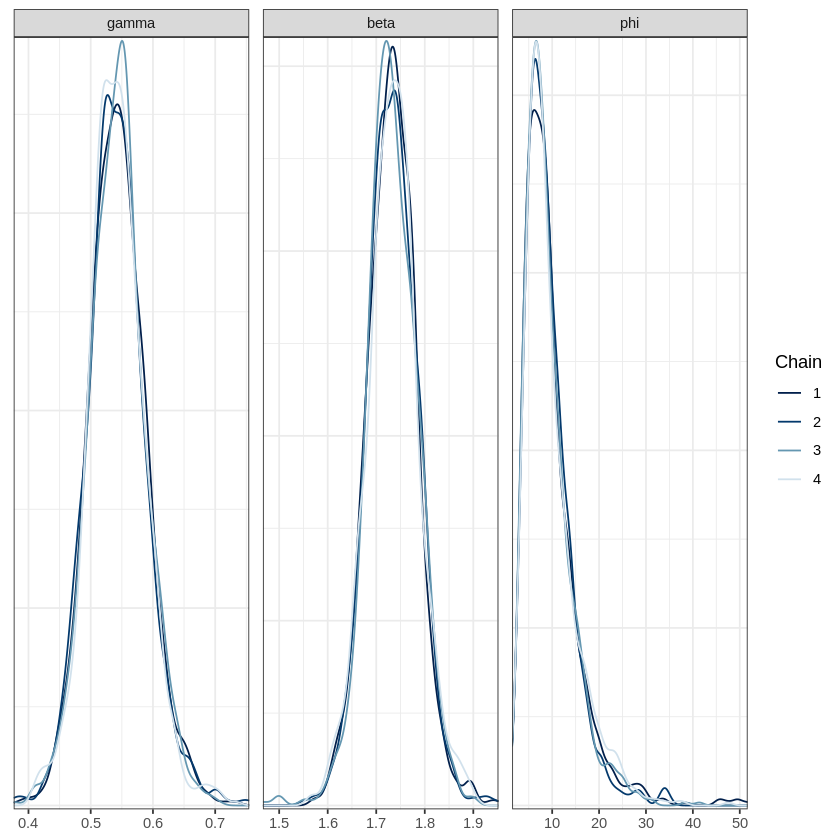

In [62]:
## Check the inference
fit$summary()

pars <- c("gamma", "beta", "phi")
bayesplot::mcmc_trace(fit$draws(inc_warmup = TRUE),
                      n_warmup = 1000, pars = pars)
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)


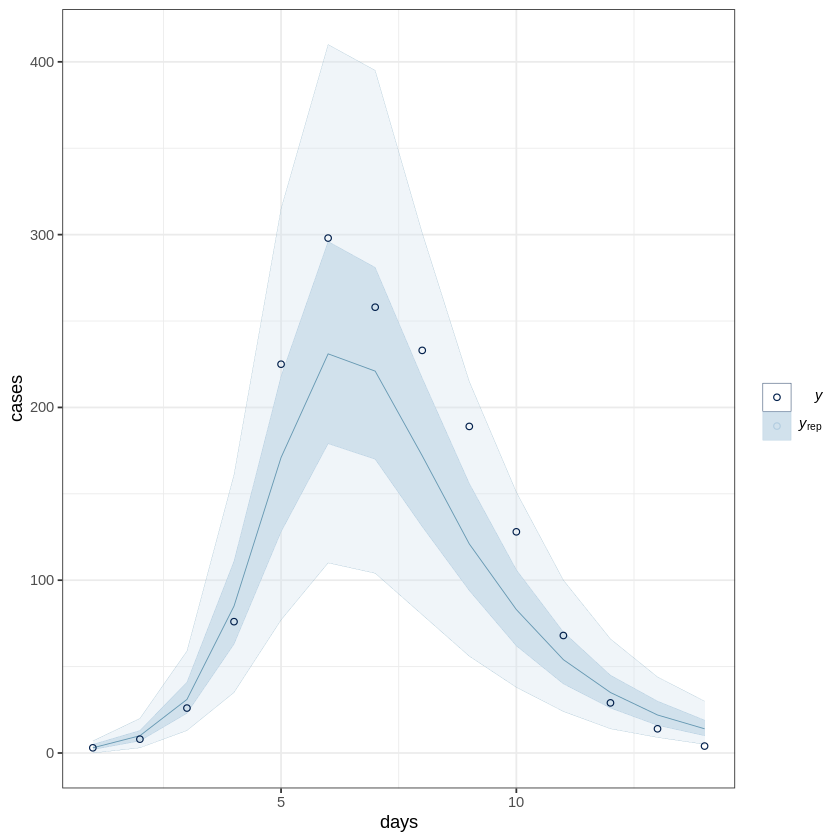

In [63]:
# Extract posterior predictive checks
pred_cases <- as.matrix(
  as_draws_df(fit$draws(variables = c("pred_cases"))))[, -(15:17)]

bayesplot::ppc_ribbon(y = data_sir$cases, yrep = pred_cases,
                      x = data_sir$ts, y_draw = "point") +
  theme_bw() +
  ylab("cases") + xlab("days")
